#### Import Modules

In [2]:
%matplotlib inline
import yaml
import csv
import os
import cv2
import json
import imageio
import math

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from skimage import data, io

from glob import glob

from keras import backend as K
from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers import Conv2D, Cropping2D, Input, UpSampling2D, Conv2DTranspose
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam

Using TensorFlow backend.


#### Read and visualize the training data

In [3]:
#Define data-paths
data_path = os.path.join('.', 'data', 'sim_training_data')
model_path = os.path.join('.', 'model')
training_image_files = glob(os.path.join(data_path, 'sim_data_capture','*.jpg'))
annotations_file = os.path.join(data_path, 'sim_data_annotations.yaml')

In [4]:
print("Number of training images: ", len(training_image_files))

Number of training images:  280


In [5]:
with open(annotations_file, 'r') as f:
    labels = pd.io.json.json_normalize(yaml.load(f))
labels.drop(columns='class', inplace=True)

In [6]:
Idx=labels.set_index(['filename']).annotations.apply(pd.Series).stack().index

boxes = pd.DataFrame(labels.set_index(['filename'])
                   .annotations.apply(pd.Series).stack().values.tolist(),index=Idx).reset_index().drop('level_1',1)
boxes['image'] = boxes['filename'].apply(lambda file: file.split('/')[-1])
boxes['filename'] = boxes['filename'].apply(lambda file: os.path.join(data_path, 'sim_data_capture',file.split('/')[-1]))
boxes['xmax'] = boxes['xmin'] + boxes['x_width']
boxes['ymax'] = boxes['ymin'] + boxes['y_height']
boxes['xmin'] = boxes['xmin'].astype(int)
boxes['ymin'] = boxes['ymin'].astype(int)
boxes['xmax'] = boxes['xmax'].astype(int)
boxes['ymax'] = boxes['ymax'].astype(int)

In [7]:
boxes = boxes[['filename', 'image','xmin', 'xmax', 'ymin', 'ymax', 'class']]
#boxes.to_csv(os.path.join(data_path,'simple_unity_labels.csv'), header=False, index=False)

Red       441
Green     130
Yellow     99
Name: class, dtype: int64


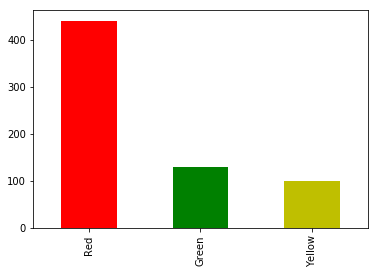

In [8]:
print(pd.value_counts(boxes['class']))
pd.value_counts(boxes['class']).plot(kind='bar', color=['r', 'g', 'y'])
plt.show()

In [ ]:
# tl_path = '\\sim_tl_extract\\'

# for index, row in boxes.iterrows():
#     image = cv2.imread(row['filename'])
#     traffic_light_image = image[row['ymin']:row['ymax'], row['xmin']:row['xmax'], :]
#     #print('Writing image to file: ',data_path+tl_path+row['filename'].split('\\')[-1].split('.')[0]+'_'+str(index)+'.jpg' )
#     cv2.imwrite(data_path+tl_path+row['filename'].split('\\')[-1].split('.')[0]+'_'+str(index)+'_'+row['class']+'.jpg',
#                 traffic_light_image)
    
# plt.imshow(traffic_light_image)


In [12]:
data_2 = pd.read_csv(os.path.join(data_path, 'capture2_annotations.csv'))
data_2['image'] = data_2['image'].apply(
    lambda file: os.path.join(data_path, 'sim_data_capture_2',file.split('/')[-1]))

In [13]:
data_2

,x,y,z,ax,ay,az,aw,image,label
0,1131.2200,1183.270,0.103159,0.0,0.0,0.043620,0.999048,.\data\sim_training_data\sim_data_capture_2\se...,0
1,1131.2910,1183.276,0.107033,0.0,0.0,0.043743,0.999043,.\data\sim_training_data\sim_data_capture_2\se...,0
2,1131.4740,1183.293,0.107202,0.0,0.0,0.043787,0.999041,.\data\sim_training_data\sim_data_capture_2\se...,0
3,1131.9830,1183.338,0.107363,0.0,0.0,0.043875,0.999037,.\data\sim_training_data\sim_data_capture_2\se...,0
4,1133.4120,1183.467,0.109284,0.0,0.0,0.044601,0.999005,.\data\sim_training_data\sim_data_capture_2\se...,0
5,1134.8650,1183.600,0.112197,0.0,0.0,0.045305,0.998973,.\data\sim_training_data\sim_data_capture_2\se...,0
6,1135.6640,1183.674,0.113795,0.0,0.0,0.045629,0.998958,.\data\sim_training_data\sim_data_capture_2\se...,0
7,1136.3910,1183.741,0.115247,0.0,0.0,0.045884,0.998947,.\data\sim_training_data\sim_data_capture_2\se...,0
8,1137.6490,1183.859,0.117395,0.0,0.0,0.046233,0.998931,.\data\sim_training_data\sim_data_capture_2\se...,0
9,1138.5820,1183.946,0.118437,0.0,0.0,0.046444,0.998921,.\data\sim_training_data\sim_data_capture_2\se...,0


#### Setup training/validation data

In [4]:
def LoadImage(file, size):
    #JPEG images are read as BGR and [0,255]
    img = cv2.imread(file)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

def get_scaled_box(norm_box, size):
    scaled_box = (int(norm_box[0]*size[0]), 
                   int(norm_box[1]*size[0]),
                   int(norm_box[2]*size[1]), 
                   int(norm_box[3]*size[1]),
                 norm_box[4])
    return scaled_box

def get_image_size(img):
    return (img.shape[1], img.shape[0])

def get_mask(img, box_list, labels):
    """
    Arguments:
    img: type - uint8: image on which to draw boxes (unmodified)
    box_list: type - object: list of normalized bounding boxes [xmin, xwidth, ymin, yheight, class]
    labels: type - string: list of class labels
    """
    encoded_labels = {label:i for i, label in enumerate(labels)}
    img_mask = np.zeros_like(img) #original image is 3 channels and we have 3 classes (R, Y, G)
    image_size = get_image_size(img_mask)
    for box in box_list:
        scaled_box = get_scaled_box(box, image_size)
        img_mask[scaled_box[2]:scaled_box[2] + scaled_box[3], 
                 scaled_box[0]:scaled_box[0] + scaled_box[1], encoded_labels[scaled_box[4]]]= 1.
    return img_mask

def draw_boxes(img, box_list, color=(0, 255, 0), thick=3):
    """
    Arguments:
    img: type - uint8: image on which to draw boxes (unmodified)
    box_list: type - object: list of normalized bounding boxes [xmin, xwidth, ymin, yheight, class]
    color: type - int: tuple of box color (0,255,0)
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    image_size = get_image_size(imcopy)
    # Draw a rectangle given bbox coordinates
    for box in box_list:
        scaled_box = get_scaled_box(box, image_size)
        cv2.rectangle(imcopy, (scaled_box[0], scaled_box[2]), 
                      (scaled_box[0]+scaled_box[1], scaled_box[2]+scaled_box[3]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
image_size = (800,600)
load_size = (640,256)
channels = 3
labels = ['Red', 'Yellow','Green']

In [6]:
#Load the training data from sim_data_capture
data = yaml.load(open(annotations_file, 'rb').read())
normalized_data = data
n_data = len(normalized_data)

annotations = []
for sample in normalized_data:
    sample['filename'] = os.path.join(data_path, 'sim_data_capture',sample['filename'].split('/')[-1])
    image_annotations = []
    for box in sample['annotations']:
        box['x_width'] /= image_size[0]
        box['xmin'] /= image_size[0]
        box['ymin'] /= image_size[1]
        box['y_height'] /= image_size[1]
        image_annotations.append([box['xmin'], box['x_width'],box['ymin'], box['y_height'], box['class']])
    annotations.append(image_annotations)

In [7]:
#Setup the image and mask arrays
X_data = np.zeros([n_data, load_size[1], load_size[0], channels], dtype=np.uint8)
y_data = np.zeros([n_data, load_size[1], load_size[0], channels], dtype=np.float32)
for i, sample in enumerate(normalized_data):
    X_data[i] = LoadImage(sample['filename'], load_size)
    y_data[i] = get_mask(X_data[i], annotations[i], labels)

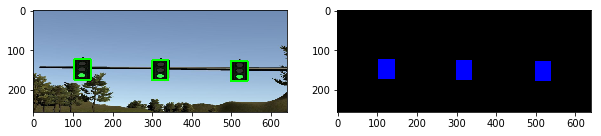

In [78]:
#Visualize an image and its mask
index = 0
image = X_data[index]
image_with_boxes = draw_boxes(X_data[index], annotations[index])

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.flip(image_with_boxes, axis=2))
plt.subplot(1,2,2)
plt.imshow(y_data[index])
plt.show()

#### Setup UNet to use for TL detection/classification

In [14]:
def LRschedule(epoch):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [10]:
def build_model(img_size, channels, lrate=0.5e-4):
    inputs = Input((img_size[1], img_size[0], channels), name = 'Input')
    inputs_norm = Lambda(lambda x: x/255 - 0.5, name = 'Normalization')(inputs)
    conv1 = Conv2D(8, 3, activation='relu', padding='same', name = 'Conv1_1')(inputs_norm)
    conv1 = Conv2D(8, 3, activation='relu', padding='same', name = 'Conv1_2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool1')(conv1)

    conv2 = Conv2D(16, 3, activation='relu', padding='same', name = 'Conv2_1')(pool1)
    conv2 = Conv2D(16, 3, activation='relu', padding='same', name = 'Conv2_2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool2')(conv2)

    conv3 = Conv2D(32, 3, activation='relu', padding='same', name = 'Conv3_1')(pool2)
    conv3 = Conv2D(32, 3, activation='relu', padding='same', name = 'Conv3_2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool3')(conv3)

    conv4 = Conv2D(64, 3, activation='relu', padding='same', name = 'Conv4_1')(pool3)
    conv4 = Conv2D(64, 3, activation='relu', padding='same', name = 'Conv4_2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool4')(conv4)

    conv5 = Conv2D(128, 3, activation='relu', padding='same', name = 'Conv5_1')(pool4)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', name = 'Conv5_2')(conv5)

    up6 = Concatenate(name = 'Merge1')([Conv2DTranspose(64, 2, strides=(2, 2), name = 'Conv2DT_1')(conv5), conv4])
    conv6 = Conv2D(64, 3, activation='relu', padding='same', name = 'Conv6_1')(up6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', name = 'Conv6_2')(conv6)

    up7 = Concatenate(name = 'Merge2')([Conv2DTranspose(32, 2, strides=(2, 2), name = 'Conv2DT_2')(conv6), conv3])
    conv7 = Conv2D(32, 3, activation='relu', padding='same', name = 'Conv7_1')(up7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same', name = 'Conv7_2')(conv7)

    up8 = Concatenate(name = 'Merge3')([Conv2DTranspose(16, 2, strides=(2, 2), name = 'Conv2DT_3')(conv7), conv2])
    conv8 = Conv2D(16, 3, activation='relu', padding='same', name = 'Conv8_1')(up8)
    conv8 = Conv2D(16, 3, activation='relu', padding='same', name = 'Conv8_2')(conv8)

    up9 = Concatenate(name = 'Merge4')([Conv2DTranspose(8, 2, strides=(2, 2), name = 'Conv2DT_4')(conv8), conv1])
    conv9 = Conv2D(8, 3, activation='relu', padding='same', name = 'Conv9_1')(up9)
    conv9 = Conv2D(8, 3, activation='relu', padding='same', name = 'Conv9_2')(conv9)

    conv10 = Conv2D(3, 1, activation='softmax', name = 'Output')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    model.compile(optimizer=Adam(lr=lrate), loss='categorical_crossentropy', metrics=['accuracy'] )
 
    return model

In [15]:
#Set hyperparameters
model_file = os.path.join(model_path, 'tl_classifier_Unet_v4.{epoch:02d}-{val_acc:.3f}.h5')
epochs = 10
batch_size = 32
lrate = 1e-3

In [16]:
tl_classifier = build_model(load_size, channels, lrate)
tl_classifier.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 256, 640, 3)   0                                            
____________________________________________________________________________________________________
Normalization (Lambda)           (None, 256, 640, 3)   0           Input[0][0]                      
____________________________________________________________________________________________________
Conv1_1 (Conv2D)                 (None, 256, 640, 8)   224         Normalization[0][0]              
____________________________________________________________________________________________________
Conv1_2 (Conv2D)                 (None, 256, 640, 8)   584         Conv1_1[0][0]                    
___________________________________________________________________________________________

In [17]:
checkpoint = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=False, period=1)
early_stopping = EarlyStopping(monitor = 'val_acc', min_delta = 0.0005, patience = 1, verbose = 1)
scheduler = LearningRateScheduler(LRschedule)

TrainingCallbacks = [checkpoint, early_stopping, scheduler]

training_history = tl_classifier.fit(x=X_data, y=y_data, batch_size=batch_size, epochs=epochs, 
                                     verbose=1, callbacks=TrainingCallbacks, 
                                     validation_split=0.1, shuffle=True)

Train on 249 samples, validate on 28 samples
Epoch 1/10
249/249 [==============================] - 27s - loss: 0.0201 - acc: 0.8197 - val_loss: 0.0371 - val_acc: 0.9903
Epoch 2/10
249/249 [==============================] - 15s - loss: 0.0199 - acc: 0.9904 - val_loss: 0.0356 - val_acc: 0.9940
Epoch 3/10
249/249 [==============================] - 16s - loss: 0.0196 - acc: 0.9912 - val_loss: 0.0328 - val_acc: 0.9941
Epoch 4/10
249/249 [==============================] - 15s - loss: 0.0193 - acc: 0.9909 - val_loss: 0.0293 - val_acc: 0.9925
Epoch 00003: early stopping


#### Check the model on test data

In [79]:
threshold = 0.4

In [93]:
test_image_files = glob(os.path.join(data_path, 'sim_data_capture_2','*.jpg'))
n_test = len(test_image_files)

In [97]:
X_test = np.zeros([n_test, load_size[1], load_size[0], channels], dtype=np.uint8)
for i, file in enumerate(test_image_files):
    X_test[i] = LoadImage(file, load_size)

In [19]:
tl_model = load_model(os.path.join(model_path, 'tl_classifier_Unet_v4.02-0.994.h5'))

In [104]:
predictions = tl_model.predict(X_test)

In [115]:
index = 200
prediction = predictions[index]
prediction[prediction >= threshold] = 1
prediction[prediction < threshold] = 0

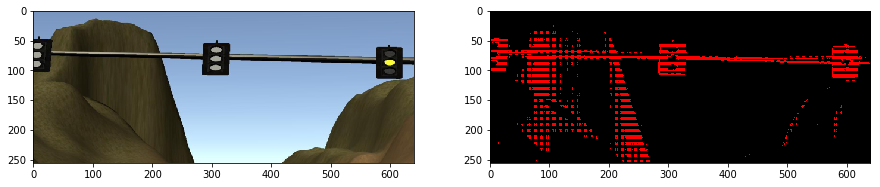

In [116]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(np.flip(X_test[index], axis=2))
plt.subplot(1,2,2)
plt.imshow(prediction)
plt.show()